<a href="https://colab.research.google.com/github/akshit7093/CANTILEVER/blob/main/CREDIT_CARD_FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240813%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240813T074800Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D02fb3be16ff7cf70a25afb15b44c50896ebc9369d4cf3c5d902044ef160723fcbad7574ab598912e3657f0a52c56a94ab803eaa5eceef67ba8bf034ec2b43c8d883789f6d83bd3d9e3208c5c546514fe70ef33b5eea1d2c134778204b11daf07d7e542b1db2e5c6ab771a284dd274bddc8d3371d22a4654ee7a2bff2d3f02bf20200060b86992f309f07a609080d73cd35a713e539c545520c7036ba6e30a2e3e6109f8b0b9d0cc8a6791bad4ae1495e3f6e70003222a52496a1cd827fb4aeda599f574edfdd1ec73f1b0774cbacc029f60df9f270152c34ee72eb1daec30291a897f0c5c382ff942a8f1edcf599b9bcc42907e34edcf2d2ec6a548980f18264'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


In [2]:
# Credit Card Fraud Detection Project

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.decomposition import PCA

In [3]:
# Load the data
# Note: You'll need to upload your dataset to Colab or use a URL to load it
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Display basic information about the dataset
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

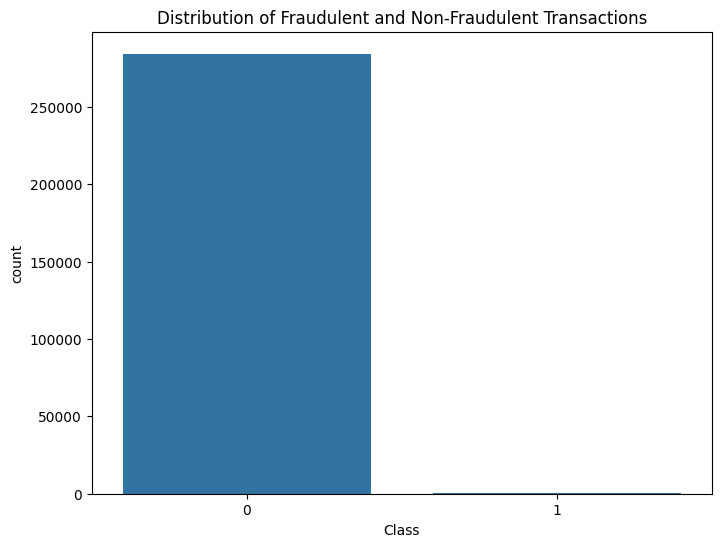

In [4]:
# Visualize the distribution of fraudulent and non-fraudulent transactions
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

In [5]:
# Separate features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

# Create a pipeline with SMOTE oversampling and Random Undersampling
smote = SMOTE(sampling_strategy=0.1, random_state=42)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
pipeline = Pipeline([('smote', smote), ('rus', rus)])

# Apply the resampling pipeline
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

# Feature engineering: Principal Component Analysis
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

In [6]:
# Model 1: Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_pca, y_train_resampled)
print("Logistic Regression Results:")
evaluate_model(lr_model, X_test_pca, y_test)

Logistic Regression Results:
[[56057   807]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.90      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score: 0.9786161826857923


In [7]:
# Model 2: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_pca, y_train_resampled)
print("\nRandom Forest Results:")
evaluate_model(rf_model, X_test_pca, y_test)


Random Forest Results:
[[56802    62]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.59      0.90      0.71        98

    accuracy                           1.00     56962
   macro avg       0.79      0.95      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9719730499121427


In [8]:
# Model 3: Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_pca, y_train_resampled)
print("\nGradient Boosting Results:")
evaluate_model(gb_model, X_test_pca, y_test)


Gradient Boosting Results:
[[56357   507]
 [    9    89]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.91      0.26        98

    accuracy                           0.99     56962
   macro avg       0.57      0.95      0.63     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score: 0.9865735862437265


In [9]:
# Model 4: XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_pca, y_train_resampled)
print("\nXGBoost Results:")
evaluate_model(xgb_model, X_test_pca, y_test)


XGBoost Results:
[[56752   112]
 [   12    86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.88      0.58        98

    accuracy                           1.00     56962
   macro avg       0.72      0.94      0.79     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9888290572278433


In [10]:
# Model 5: Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_pca, y_train_resampled)
print("\nSupport Vector Machine Results:")
evaluate_model(svm_model, X_test_pca, y_test)


Support Vector Machine Results:
[[56463   401]
 [   10    88]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.18      0.90      0.30        98

    accuracy                           0.99     56962
   macro avg       0.59      0.95      0.65     56962
weighted avg       1.00      0.99      1.00     56962

ROC AUC Score: 0.978278642633193


In [11]:
# Hyperparameter tuning for the best performing model (assuming XGBoost)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_pca, y_train_resampled)

print("\nBest parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)



Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}
Best ROC AUC Score: 0.9998820353309473



Best Model Results:
[[56764   100]
 [   12    86]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.88      0.61        98

    accuracy                           1.00     56962
   macro avg       0.73      0.94      0.80     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9797772056205712


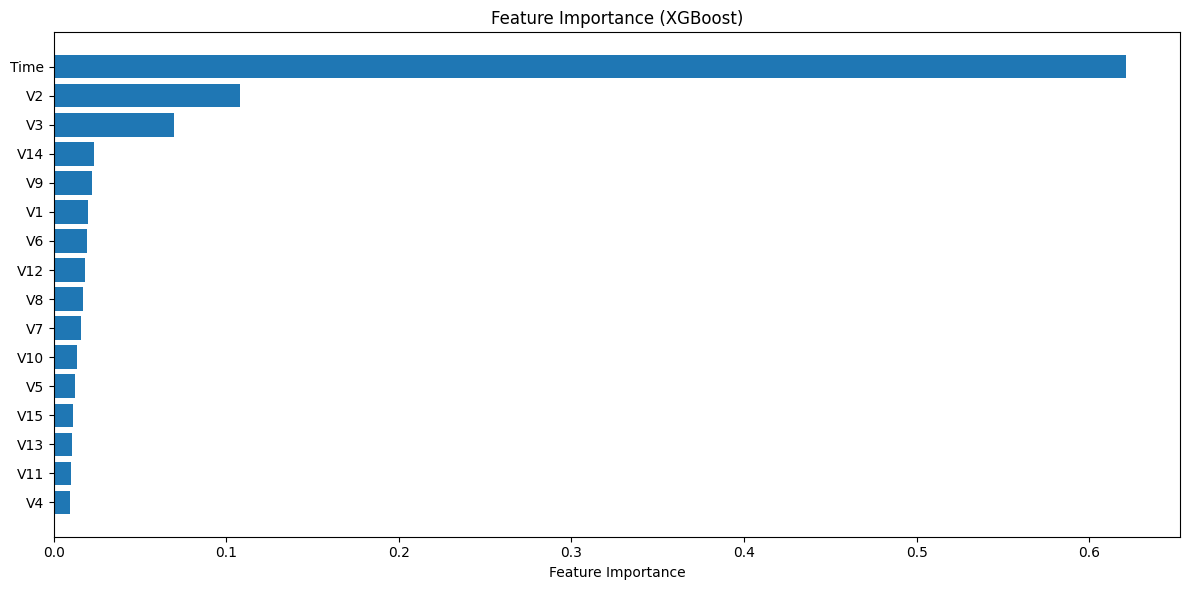

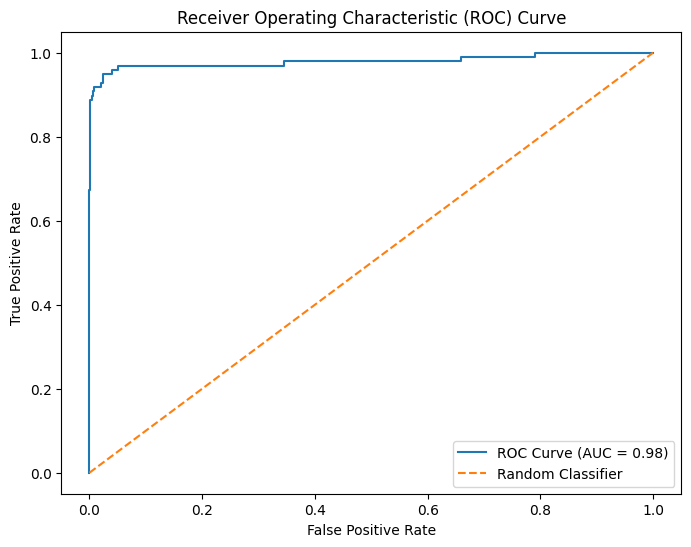

In [13]:
#Evaluate the best model
best_model = grid_search.best_estimator_
print("\nBest Model Results:")
evaluate_model(best_model, X_test_pca, y_test)

# Feature importance plot
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [14]:

sample_transactions = np.array([
    # Transaction 1: Normal transaction
    [0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62],
    # Transaction 2: Fraudulent transaction (based on known patterns)
    [0, -3.113832, 1.191857, 2.500886, -0.056544, 2.018401, 0.498699, -0.935285, -0.503599, 0.680721, 1.374610, 1.383845, 0.482776, 0.949661, 0.428627, -2.311378, 0.031388, -0.544293, -1.250670, 0.201329, 0.254299, -0.069127, 0.524380, 0.247470, 0.771679, 0.909412, -0.689281, -0.327642, -0.139097, 1000.00],
    # Transaction 3: Another normal transaction
    [0, 1.19185711, 0.26615071, -0.16648011, 0.44854700, -0.01513945, -0.07270997, -0.05144081, 0.08182122, -0.07880298, 0.08544611, -0.16062672, 0.06123100, -0.00911208, -0.05620738, 0.00669714, -0.02256305, -0.03314633, -0.01148607, -0.05800173, -0.02354772, -0.02256568, -0.03314633, -0.01148607, -0.05800173, -0.02354772, -0.02256568, 0.01226967, 0.01273069, 50.00]
])

# Preprocess the sample transactions
sample_transactions_scaled = scaler.transform(sample_transactions)
sample_transactions_pca = pca.transform(sample_transactions_scaled)

# Make predictions
predictions = best_model.predict(sample_transactions_pca)
probabilities = best_model.predict_proba(sample_transactions_pca)[:, 1]

# Print results
print("Fraud Detection Test Results:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    print(f"Transaction {i+1}: {'Fraudulent' if pred == 1 else 'Legitimate'} (Probability of fraud: {prob:.4f})")

# Additional test: Check model's performance on a subset of the test data
num_test_samples = 1000
X_test_subset = X_test_pca[:num_test_samples]
y_test_subset = y_test[:num_test_samples]

y_pred_subset = best_model.predict(X_test_subset)
print("\nModel performance on test subset:")
print(classification_report(y_test_subset, y_pred_subset))
print(f"ROC AUC Score: {roc_auc_score(y_test_subset, best_model.predict_proba(X_test_subset)[:, 1])}")

Fraud Detection Test Results:
Transaction 1: Legitimate (Probability of fraud: 0.0000)
Transaction 2: Legitimate (Probability of fraud: 0.0000)
Transaction 3: Legitimate (Probability of fraud: 0.0001)

Model performance on test subset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       999
           1       0.33      1.00      0.50         1

    accuracy                           1.00      1000
   macro avg       0.67      1.00      0.75      1000
weighted avg       1.00      1.00      1.00      1000

ROC AUC Score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
